<a href="https://colab.research.google.com/github/MrKozelberg/wavefunction_perceptron/blob/spectrum_laplace_operator/spectrum_laplace_operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying the perceptron to the Laplace operator's eigen-problem

## Imports

In [2]:
import numpy as np  # to work with arrays
import matplotlib.pyplot as plt  # to make figures

# PyTorch
import torch
from torch import nn

## Detect available device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Definition of an activation function and its derivatives

In [4]:
def f0(x):
    return torch.tanh(x)
  
def f1(x):
  return 1/torch.cosh(x)**2
  
def f2(x):
  return -2*torch.sinh(x)/torch.cosh(x)**3

## Class for the perceptron-wavefunction 

In [5]:
class WaveFunction(nn.Module):

  def __init__(self, N, layersizes):
    self.N = N  # size of the input vector
    self.layersizes = layersizes  # sizes of hidden layers
    self.l = len(self.layersizes)  # number of hidden layers

    super(WaveFunction, self).__init__()
        
    self.linear_tanh_stack = nn.Sequential()
    for i in range(self.l + 1):
      if i == 0:
        self.linear_tanh_stack.append(nn.Linear(N, self.layersizes[i]))
      elif i == self.l:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1], 1))
      else:
        self.linear_tanh_stack.append(nn.Linear(self.layersizes[i-1],
                                                self.layersizes[i]))
      self.linear_tanh_stack.append(nn.Tanh())
    
    self.h = [None] * (self.l + 1)  # outputs of the layers

  
  def forward(self, x):
    for i in range(self.l + 1):
      if i == 0:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](x))
      else:
        self.h[i] = self.linear_tanh_stack[2*i+1](
            self.linear_tanh_stack[2*i](self.h[i-1]))
      
    return self.h[-1]


  def grad(self, x):
    """
    finds the gradient of the wave function at a given point x
    """
    _ = self.forward(x)  # computes outputs of the layers #
    gradient = torch.zeros(x.shape) #[None] * self.N #
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device) #
      dh_dx[t] = 1 # 

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)   
        
      # print(dh_dx.shape, gradient[t].shape)
      
      gradient[:,t] = dh_dx.reshape(-1)

    return gradient
  

  def laplac(self, x):
    """
    finds the Laplacian of the wave function at a given point x
    """
    y = self.forward(x)  # computes outputs of the layers
    laplacian = 0.0
    for t in range(self.N):
      dh_dx = torch.zeros(self.N).to(device)
      dh_dx[t] = 1

      d2h_dx2 = torch.zeros(self.N).to(device)

      for i in range(self.l + 1):
        w = self.linear_tanh_stack[2*i].weight
        b = self.linear_tanh_stack[2*i].bias

        # firstly, the new value of the second derivative computes as it is 
        # used the previous value of the first derivative

        if i == 0:
          d2h_dx2 = f2(x @ w.T + b) * (dh_dx @ w.T)**2
        else:
          d2h_dx2 = f2(self.h[i-1] @ w.T + b) * (dh_dx @ w.T)**2\
                    + f1(self.h[i-1] @ w.T + b) * (d2h_dx2 @ w.T)

        if i == 0:
          dh_dx = f1(x @ w.T + b) * (dh_dx @ w.T)
        else:
          dh_dx = f1(self.h[i-1] @ w.T + b) * (dh_dx @ w.T) 
      
      # print(d2h_dx2)
      laplacian += d2h_dx2
    
    return laplacian

In [69]:
def A(x_):
  return torch.sum((x_ - 1/2)**2-1/4, axis=1)
  
def Ax(x_):
  return 2*(x_-1/2)
  
def Axx(x_):
  return 2.0

def train_loop(N, N_batch, M, wf, optimizer):
  """
  N --- a size of the input vector, its dimension
  M --- total number of iterations
  """

  loss_fn = nn.L1Loss()
  
  for i in range(M):
    x_test = torch.rand((N_batch, N)).to(device)

    phi_test = wf(x_test).reshape(len(x_test)).to(device)
    phix_test = wf.grad(x_test).to(device)
    phixx_test = wf.laplac(x_test).reshape(len(x_test)).to(device)

    # если задавать нужное значение энергии, то всё получается
    I = torch.mean( (phixx_test * A(x_test) \
                     + 2 * torch.sum(Ax(x_test) * phix_test, axis=1) \
                     + Axx(x_test) * phi_test \
                     + np.pi**2*phi_test*A(x_test))**2 )

    # Compute loss
    loss = loss_fn(I, torch.tensor(0.0, device=device))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 500 == 0:
      print(f"Residual: {loss.item():>0.4E} [{i+1:>5d} / {M:>5d}]")

# 1D

In [10]:
def plot_compar(wf):
  x = torch.linspace(1e-2,1-1e-2,100).reshape((-1, N)).to(device)
  y = wf(x) * A(x).reshape((-1,N))

  x = x.cpu().detach().numpy()
  y = y.cpu().detach().numpy()

  plt.plot(x, (y/y.mean())**2,
           label='What we get')
  
  plt.plot(x, (np.sin(x*np.pi)/np.sin(x*np.pi).mean())**2,
           label='What we should get')

  plt.legend()
  plt.xlim(0,1)
  plt.ylim(0.0,None)

  plt.show()

## Initialization of our wavefunction

In [11]:
N = 1  # size of the input vector
wf = WaveFunction(N, [10]*3).to(device) ## число внутренних слоёв должно быть той же четности, что и номер состояния

## Its training

In [12]:
optimizer = torch.optim.SGD(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 10
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10, 1000, wf, optimizer)
  scheduler.step()

  if (t+1) % 5 == 0:
    plot_compar(wf)


 Epoch 1
-------------------------------


KeyboardInterrupt: ignored

# 2D

In [16]:
N = 2
wf = WaveFunction(N, [10**N]*3).to(device) 

In [17]:
optimizer = torch.optim.SGD(params = wf.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
epochs = 10
for t in range(epochs):
  print(f"\n Epoch {t+1}\n-------------------------------")
  train_loop(N, 10**N, 1000, wf, optimizer)
  scheduler.step()



 Epoch 1
-------------------------------
Residual: 4.4294E-05 [  500 /  1000]
Residual: 2.8236E-05 [ 1000 /  1000]

 Epoch 2
-------------------------------
Residual: 1.8738E-05 [  500 /  1000]
Residual: 1.1112E-05 [ 1000 /  1000]

 Epoch 3
-------------------------------
Residual: 8.6496E-06 [  500 /  1000]
Residual: 6.2687E-06 [ 1000 /  1000]

 Epoch 4
-------------------------------
Residual: 4.9045E-06 [  500 /  1000]


KeyboardInterrupt: ignored

In [73]:
x = np.linspace(0,1,100)
xs, ys = np.meshgrid(x,x, sparse=True)

X = np.array([[xs[0,i], ys[j,0]] for i in range(100) for j in range(100)])
X = torch.tensor(X).to(device)

Z = A(X.float())

Text(0, 0.5, '$x_2$')

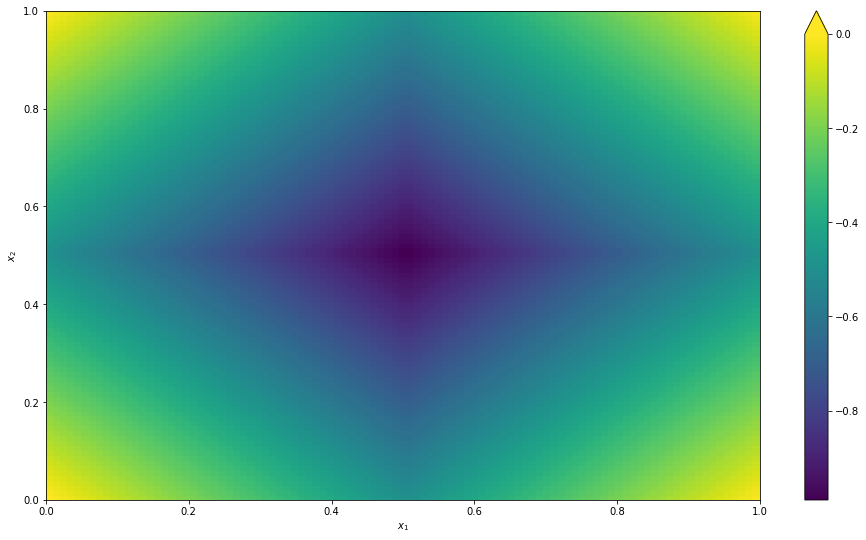

In [76]:
X = X.reshape(100,100,2)

fig, ax = plt.subplots(1, 1, figsize=(16,9))

pcm = ax.pcolormesh(x, x, Z.reshape(100,100).cpu().detach().numpy())

fig.colorbar(pcm, ax=ax, extend='max')

# plt.contourf(x, x, Z.reshape(100,100).cpu().detach().numpy())
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

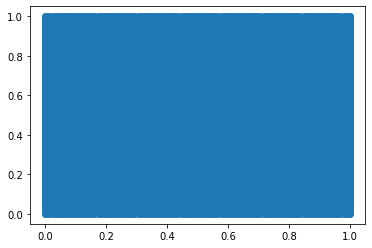

In [31]:
plt.scatter(x_.cpu().numpy(), y_.cpu().numpy())

In [61]:
X.reshape(100,100,2)

plt.scatter(x_.cpu().numpy(), y_.cpu().numpy())

tensor([[[0.0000, 0.0000],
         [0.0000, 0.0101],
         [0.0000, 0.0202],
         ...,
         [0.0000, 0.9798],
         [0.0000, 0.9899],
         [0.0000, 1.0000]],

        [[0.0101, 0.0000],
         [0.0101, 0.0101],
         [0.0101, 0.0202],
         ...,
         [0.0101, 0.9798],
         [0.0101, 0.9899],
         [0.0101, 1.0000]],

        [[0.0202, 0.0000],
         [0.0202, 0.0101],
         [0.0202, 0.0202],
         ...,
         [0.0202, 0.9798],
         [0.0202, 0.9899],
         [0.0202, 1.0000]],

        ...,

        [[0.9798, 0.0000],
         [0.9798, 0.0101],
         [0.9798, 0.0202],
         ...,
         [0.9798, 0.9798],
         [0.9798, 0.9899],
         [0.9798, 1.0000]],

        [[0.9899, 0.0000],
         [0.9899, 0.0101],
         [0.9899, 0.0202],
         ...,
         [0.9899, 0.9798],
         [0.9899, 0.9899],
         [0.9899, 1.0000]],

        [[1.0000, 0.0000],
         [1.0000, 0.0101],
         [1.0000, 0.0202],
         ...,
 